In [1]:
import warnings
warnings.filterwarnings('ignore')
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.decomposition import IncrementalPCA
sns.set_style('white')

analogies_path = Path('data', 'analogies-en.txt')
glove_path = Path('data', 'glove')

In [2]:
import gensim

gensim.__version__

'3.8.3'

In [3]:
# WikiPedia
glove_wiki_file= glove_path / 'glove.6B.300d.txt'
word2vec_wiki_file = glove_path / 'glove.wiki.gensim.txt'
glove2word2vec(glove_input_file=glove_wiki_file, word2vec_output_file=word2vec_wiki_file)

(400000, 300)

In [4]:
# Twitter Data
glove_twitter_file= glove_path / 'glove.twitter.27B.200d.txt'
word2vec_twitter_file = glove_path / 'glove.twitter.gensim.txt'
glove2word2vec(glove_input_file=glove_twitter_file, word2vec_output_file=word2vec_twitter_file)

(1193514, 200)

In [5]:
# Common Crawl
glove_crawl_file= glove_path / 'glove.840B.300d.txt'
word2vec_crawl_file = glove_path / 'glove.crawl.gensim.txt'
glove2word2vec(glove_input_file=glove_crawl_file, word2vec_output_file=word2vec_crawl_file)

(2196017, 300)

In [7]:
# Evaluate embeddings
results_path = Path('results', 'glove')

def eval_analogies(file_name, vocab=30000):
    model = KeyedVectors.load_word2vec_format(file_name, binary=False)
    accuracy = model.wv.accuracy(analogies_path, restrict_vocab=vocab, case_insensitive=True)
    return (pd.DataFrame([[c['section'], len(c['correct']), len(c['incorrect'])] for c in accuracy],
                         columns=['category', 'correct', 'incorrect'])
            .assign(samples=lambda x: x.correct.add(x.incorrect))
            .assign(average=lambda x: x.correct.div(x.samples))
            .drop(['correct', 'incorrect'], axis=1))

result = eval_analogies(word2vec_twitter_file, vocab=100000)

In [8]:
# twitter result
twitter_result = eval_analogies(word2vec_twitter_file, vocab=100000)
twitter_result.to_csv(glove_path / 'accuracy_twitter.csv', index=False)
twitter_result

,category,samples,average
0,capital-common-countries,462,0.701299
1,capital-world,930,0.690323
2,city-in-state,3644,0.350714
3,currency,268,0.018657
4,family,342,0.824561
5,gram1-adjective-to-adverb,650,0.143077
6,gram2-opposite,342,0.365497
7,gram3-comparative,1260,0.757937
8,gram4-superlative,930,0.686022
9,gram5-present-participle,702,0.750712


In [9]:
# wiki result
wiki_result = eval_analogies(word2vec_wiki_file, vocab=100000)
wiki_result.to_csv(glove_path / 'accuracy_wiki.csv', index=False)
wiki_result

,category,samples,average
0,capital-common-countries,506,0.948617
1,capital-world,8372,0.964644
2,city-in-state,4242,0.599953
3,currency,752,0.174202
4,family,506,0.881423
5,gram1-adjective-to-adverb,992,0.225806
6,gram2-opposite,756,0.285714
7,gram3-comparative,1332,0.882132
8,gram4-superlative,1056,0.746212
9,gram5-present-participle,1056,0.699811


In [10]:
# Common Crawl result
crawl_result = eval_analogies(word2vec_crawl_file, vocab=100000)
crawl_result.to_csv(glove_path / 'accuracy_crawl.csv', index=False)
crawl_result

,category,samples,average
0,capital-common-countries,506,0.946640
1,capital-world,4290,0.917483
2,city-in-state,4242,0.706742
3,currency,206,0.184466
4,family,420,0.978571
5,gram1-adjective-to-adverb,992,0.388105
6,gram2-opposite,702,0.363248
7,gram3-comparative,1332,0.876877
8,gram4-superlative,1122,0.919786
9,gram5-present-participle,1056,0.827652


In [12]:
# Combine & compare results
cat_dict = {'capital-common-countries':'Capitals', 'capital-world':'Capitals RoW',
            'city-in-state':'City-State', 'currency':'Currency', 'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb', 'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative', 'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.', 'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense', 'gram8-plural':'Plural', 'gram9-plural-verbs':'Plural Verbs',
            'total':'Total'}

accuracy = (twitter_result.assign(glove='Twitter').append(wiki_result.assign(glove='Wiki'))
            .append(crawl_result.assign(glove='Crawl')))

accuracy.category = accuracy.category.replace(cat_dict)
accuracy = accuracy.rename(columns=str.capitalize)

accuracy.to_csv(results_path / 'accuracy.csv', index=False)

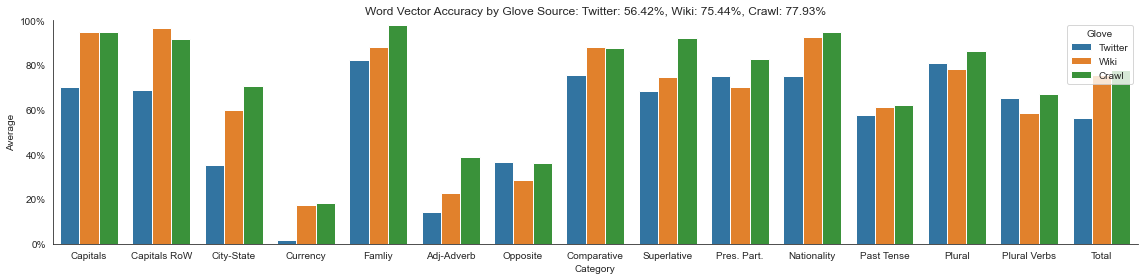

In [13]:
accuracy = pd.read_csv(results_path / 'accuracy.csv')

fig, ax = plt.subplots(figsize=(16, 4))
sns.barplot(x='Category', y='Average', hue='Glove', data=accuracy, ax=ax)
ax.set_title(f'Word Vector Accuracy by Glove Source: Twitter: {0.564228:.2%}, Wiki: {0.75444:.2%}, Crawl: {0.779347:.2%}')
ax.set_ylim(0,1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'glove_accuracy', dpi=300);

In [14]:
# Visualize Embeddings
model = KeyedVectors.load_word2vec_format(word2vec_wiki_file, binary=False)
accuracy = model.accuracy(questions=str(analogies_path), restrict_vocab=100000)
vectors = model.vectors[:100000]
vectors /= norm(vectors, axis=1).reshape(-1, 1)
vectors.shape

(100000, 300)

In [15]:
words = model.index2word[:100000]
word2id = {w:i for i, w in enumerate(words)}

In [16]:
# Project Embedding into 2D
pca = IncrementalPCA(n_components=2)

vectors2D = pca.fit_transform(vectors)
pd.Series(pca.explained_variance_ratio_).mul(100)

0    2.604632
1    1.293812
dtype: float64

In [19]:
# Plot Analogy Examples
results = pd.DataFrame()
correct = incorrect = 0
for section in accuracy:
    correct += len(section['correct'])
    incorrect += len(section['incorrect'])
    df = pd.DataFrame(section['correct']).apply(lambda x: x.str.lower()).assign(section=section['section'])
    results = pd.concat([results, df])

def find_most_similar_analogy(v):
    """Find analogy that most similar in 2D"""
    v1 = vectors2D[v[1]] - vectors2D[v[0]]
    v2 = vectors2D[v[3]] - vectors2D[v[2]]
    idx, most_similar = None, np.inf

    for i in range(len(v1)):
        similarity = cosine(v1[i], v2[i])
        if similarity < most_similar:
            idx = i
            most_similar = similarity
    return idx

def get_plot_lims(coordinates):
    xlim, ylim = coordinates.agg(['min', 'max']).T.values
    xrange, yrange = (xlim[1] - xlim[0]) * .1, (ylim[1] - ylim[0]) * .1
    xlim[0], xlim[1] = xlim[0] - xrange, xlim[1] + xrange
    ylim[0], ylim[1] = ylim[0] - yrange, ylim[1] + yrange
    return xlim, ylim

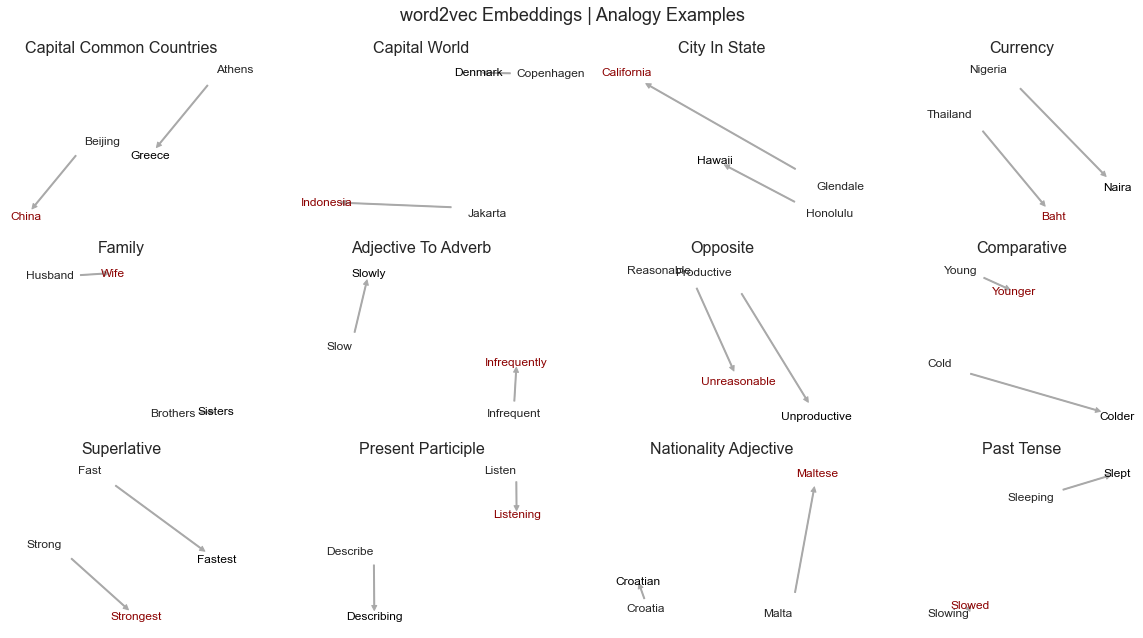

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 9))
axes = axes.flatten()
fc = ec = 'darkgrey'
for s, (section, result) in enumerate(results.groupby('section')):
    if s > 11:
        break

    df = result.drop('section', axis=1).apply(lambda x: x.map(word2id))
    most_similar_idx = find_most_similar_analogy(df)

    best_analogy = result.iloc[most_similar_idx, :4].tolist()

    analogy_idx = [words.index(word) for word in best_analogy]
    best_analogy = [a.capitalize() for a in best_analogy]

    coords = pd.DataFrame(vectors2D[analogy_idx])  # xy array

    xlim, ylim = get_plot_lims(coords)
    axes[s].set_xlim(xlim)
    axes[s].set_ylim(ylim)

    for i in [0, 2]:
        axes[s].annotate(text=best_analogy[i], xy=coords.iloc[i+1], xytext=coords.iloc[i],
                         arrowprops=dict(width=1,headwidth=5, headlength=5, fc=fc, ec=ec, shrink=.1),
                         fontsize=12)
        axes[s].annotate(text=best_analogy[i+1], xy=coords.iloc[i+1], xytext=coords.iloc[i+1], va='center'
                         , ha='center', fontsize=12, color='darkred' if i == 2 else 'k')

    axes[s].axis('off')
    title = ' '.join([s.capitalize() for s in section.split('-') if not s.startswith('gram')])
    axes[s].set_title(title, fontsize=16)

fig.suptitle('word2vec Embeddings | Analogy Examples', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)